In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [28]:
class Value:
    def __init__(self,data, _children=(), _op = '', label = ''): 
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._grad = 0 

    def __repr__(self): #If this is not present, the values would be printed out in an ugly manner
        return f"Value(data = {self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') #adding and feeding the children and previous values
        return out
        
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') #adding and feeding the children and previous values
        return out

    def tanh(self):
        out = Value((math.exp(self.data * 2) - 1) / (math.exp(self.data * 2) + 1), (self, ), 'tanh')
        return out

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
l = d * f; l.label = 'L'
        
# Children keeps track of what values produces what other values
# prev is a set that tracks of the previous values
# op keeps track of the operations' labels for the user to understand easily
# label helps us keep track of variable names 
'''
grad is used for gradient descents and differentiation
kept 0 which symbolises that gradient would not have an effect on the output value initially,
which is noramlly the case in backprop.
''' 


'\ngrad is used for gradient descents and differentiation\nkept 0 which symbolises that gradient would not have an effect on the output value initially,\nwhich is noramlly the case in backprop.\n'

In [29]:
from graphviz import Digraph

def trace(root):
    #builds a set of all the nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'}) #LR - left to right

    nodes, edges= trace(root)
    for n in nodes:
        uid = str(id(n))
        #for value in the graph, create a rectangular record for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n._grad), shape = 'record')

        if n._op:
            # if this value is a result of some operation, create a node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this with an edge
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connecting n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

NOW WE TRY TO MANUALLY BACKPROPOGATE THROUGH A NEURON

A NEURON, AS WE KNOW CONSISTS OF SUMMATION OF WEIGHTS AND BIAS. WHICH IS PAIRED WITH AN ACTIVSTION FUNCTION AT THE END

THIS ACTIVATION FUNCTION CAN BE ANY FUNC LIKE ReLU, tanh, SIGMOID ETC.

IN THIS EXAMPLE, WE WILL BE USING tanh


TO PLOT A tanh GRAPH, IT CAN BE DONE AS FOLLOWS

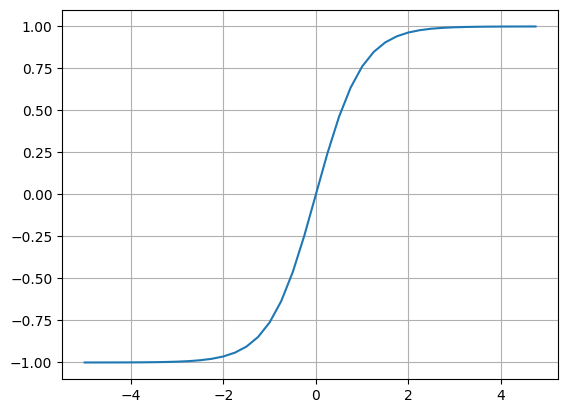

In [30]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25)));
plt.grid()

THUS THE VALUES ARE MAXXED AND MINIMISED TO 1 AND -1 RESP. SMOOTHLY TO GET A VALUE THAT CAN BE WORKED UPON

# heading 2

building out a neuron

In [31]:
#inout x1, x2 and weights w1, w2

x1 = Value(2.0, label = 'x1')
w1 = Value(-3.0, label = 'w1')
x2 = Value(0.0, label = 'x2')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.88137, label = 'bias')

#calculation of a neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

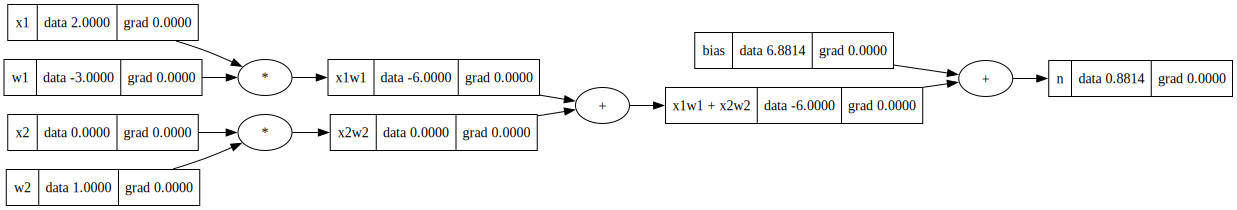

In [32]:
draw_dot(n)

NOW IMPLEMENTING AN ACTIVATION FUNCTION ON THE NEURON (tanh)

In [33]:
o = n.tanh(); o.label = 'o'

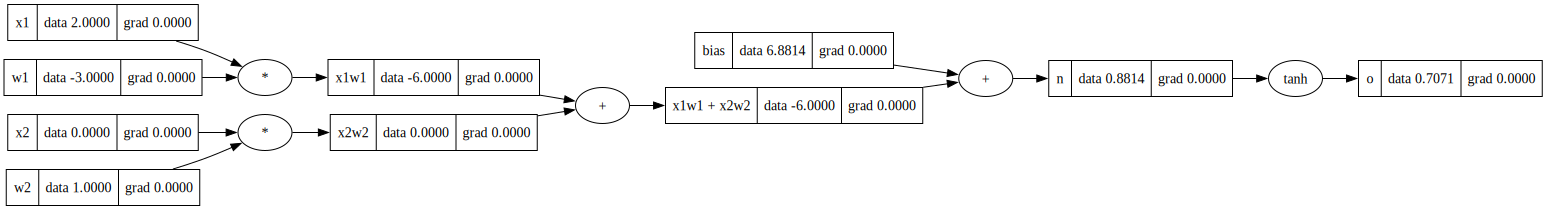

In [34]:
draw_dot(o)

# HEADING 2

CALCULATING THE GRADIENTS. 
WE KNOW FOR THE LAST CHILD NODE (o), THE GRADIENT IS ALWAYS 1.

In [35]:
o._grad = 1.0

CALCULATING FOR tanh

o = tanh(n)

do / dn = d(tanh) / do

d(tanh x) / dx = 1 - tanh**2 * x

d(tanh n) / dn = 1 - o**2

In [36]:
o.data
n._grad = 1 - o.data**2
n._grad

0.5000025364090595

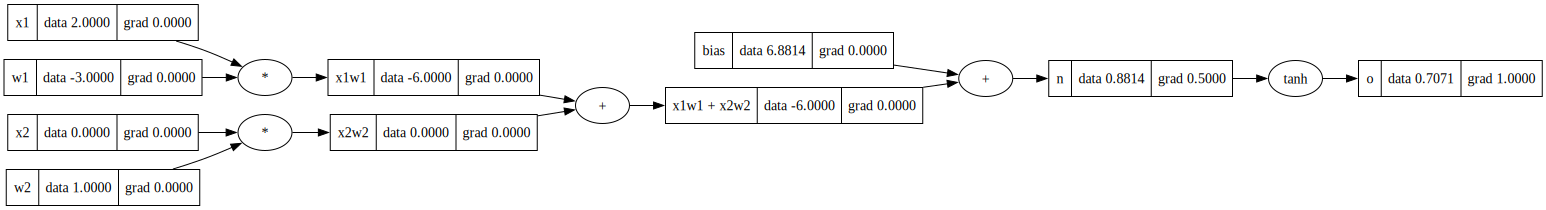

In [37]:
draw_dot(o)

ASSIGNING ALL THE GRADIENTS ACCORDING TO THEIR OPERATIONS

In [38]:
b._grad = n._grad
x1w1x2w2._grad = n._grad
x1w1._grad = x1w1x2w2._grad
x2w2._grad = x1w1x2w2._grad
x1._grad = w1.data * x1w1._grad
w1._grad = x1.data * x1w1._grad
x2._grad = w2.data * x2w2._grad
w2._grad = x2.data * x2w2._grad

In [ ]:
draw_dot(o)

IMPLEMENTING A BACKWARD FUNCTION SO WE DONT HAVE TO DO IT MANUALLY EVERYTIME


In [79]:
class Value:
    def __init__(self,data, _children=(), _op = '', label = ''): 
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._grad = 0 
        self._backward = lambda: None

    def __repr__(self): #If this is not present, the values would be printed out in an ugly manner
        return f"Value(data = {self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') #adding and feeding the children and previous values

        def _backward():
            self._grad += 1.0 * out._grad
            other._grad += 1.0 * out._grad
            
        out._backward = _backward 
        return out
        
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') #adding and feeding the children and previous values
        
        def _backward():
            self._grad += other.data * out._grad
            other._grad += self.data  * out._grad
            
        out._backward = _backward
        return out

    def tanh(self):
        out = Value((math.exp(self.data * 2) - 1) / (math.exp(self.data * 2) + 1), (self, ), 'tanh')
        
        def _backward():
            self._grad += (1 - out.data**2) * out._grad
            
        out._backward = _backward
        return out

    def backward(self):
        topo = [] #building a topo list
        visited = set() #building a visited set to keep track of which nodeshave already been visited.
        def build_topo(v):
            if v not in visited:
                visited.add(v) # adding in visited if the node has not already been visited
                for child in v._prev:
                    build_topo(child) # recursive function till the end
                topo.append(v) # adding the values in the topo list
        build_topo(self) # calling after the function is defined
    
        self._grad = 1.0 # setting the gradient of the farthest child node as 1 for calculating gradients
        for node in reversed(topo): # since the elements in the topo are in the reversed order (starting from basic inputs)
            node._backward() # calling every nodes' ._backward() function
            

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
l = d * f; l.label = 'L'
        
# Children keeps track of what values produces what other values
# prev is a set that tracks of the previous values
# op keeps track of the operations' labels for the user to understand easily
# label helps us keep track of variable names 
# _backward keeps track of the input and output gradients so that it is useful to calculate every variable's gradients. The labda is set to None by default
'''
grad is used for gradient descents and differentiation
kept 0 which symbolises that gradient would not have an effect on the output value initially,
which is noramlly the case in backprop.
''' 

'''
for calculating gardients in an additon operation, we know that the gradients are simple passed down from the child node to the parent node.
therefore, defining a function for calculating backward propogation, _backward.
what this does is, it calculates the gradients for the two inputs by multiplying the data of the child (child.data) to 1.
because thats what it basically does hahaha.
'''

'''
for calculating gardients in an multiplication operation, we know that the gradients are simply the product of the data of their other equivalent node and the gradient of their child node.
therefore, defining a function for calculating backward propogation, _backward.
what this does is, it calculates the gradients for the two inputs by multiplying the data of the equivalent node (equivalent.data) to the child node gradient.
'''

'''
THERES A BUG HERE. Basically, we have been using variables that are used just once. therefore, their gradient was only taken into account for one time only.

but now if we have variables,  let's a and b and b = a + a. the analytical derivative of this would be 2 (db / da).
but our derivative function only counts it once. therefore, the gradients need to be accumulated at a place for further addition.

thus, we add and evaluate everybody's gradients. putting += in the ._backward function of every operation, instead of the traditional +
'''

"\nTHERES A BUG HERE. Basically, we have been using variables that are used just once. therefore, their gradient was only taken into account for one time only.\n\nbut now if we have variables,  let's a and b and b = a + a. the analytical derivative of this would be 2 (db / da).\nbut our derivative function only counts it once. therefore, the gradients need to be accumulated at a place for further addition.\n\nthus, we add and evaluate everybody's gradients. putting += in the ._backward function of every operation, instead of the traditional +\n"

In [80]:
#inout x1, x2 and weights w1, w2

x1 = Value(2.0, label = 'x1')
w1 = Value(-3.0, label = 'w1')
x2 = Value(0.0, label = 'x2')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.88137, label = 'bias')

#calculation of a neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); label = 'o'

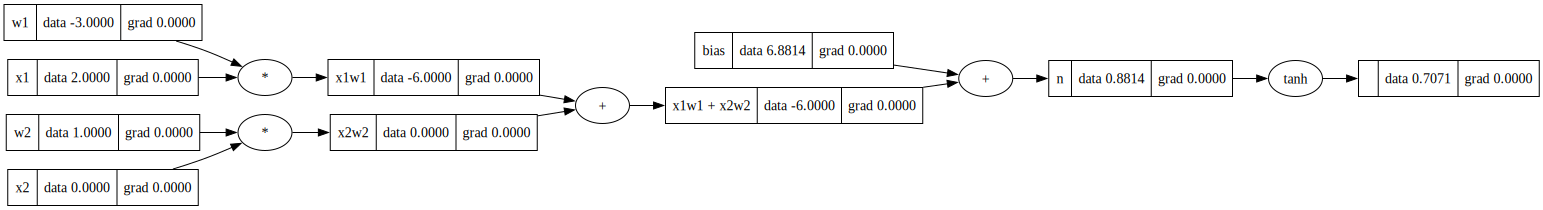

In [76]:
draw_dot(o)

NOW WE JUST CALL THE FUNCTION IN THE PROPER ORDER GOING BACKWARDS

KEEP IN MIND, WE NEED TO INITIALISE THE GRADIENT FOR o TO 1 BEFORE BACKPROPOGATING FROM o

In [44]:
o._grad = 1.0

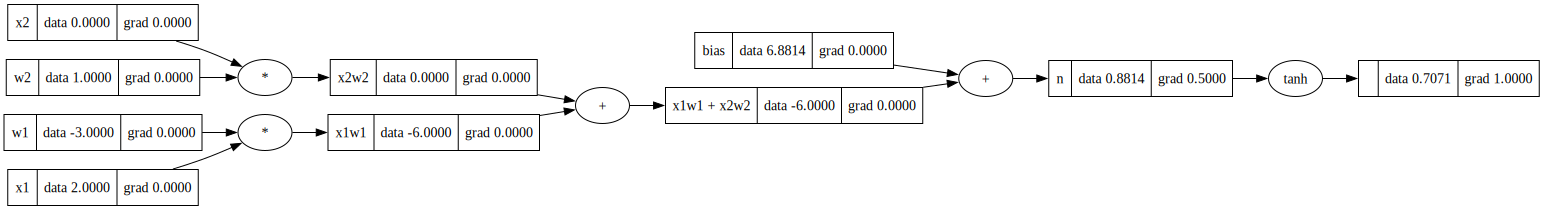

In [45]:
o._backward()
draw_dot(o)

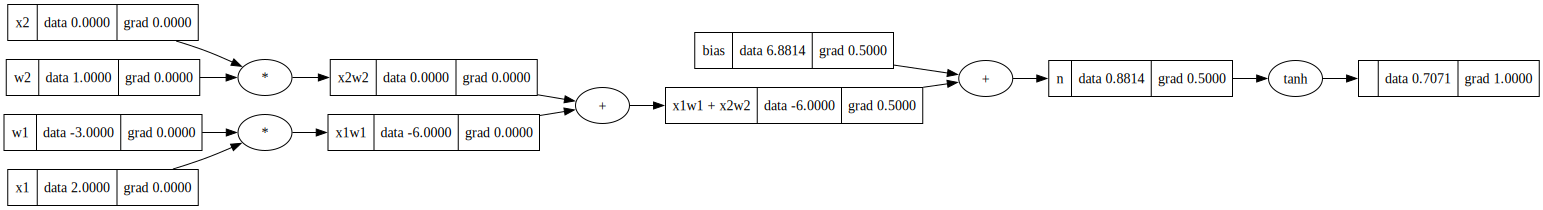

In [46]:
n._backward()
draw_dot(o)

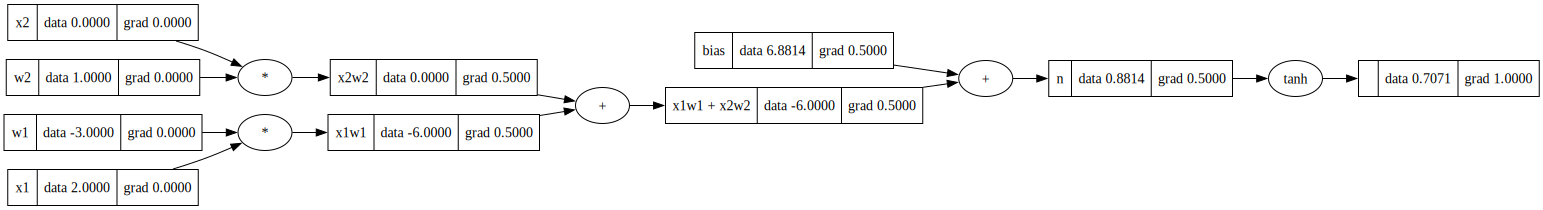

In [47]:
x1w1x2w2._backward()
draw_dot(o)

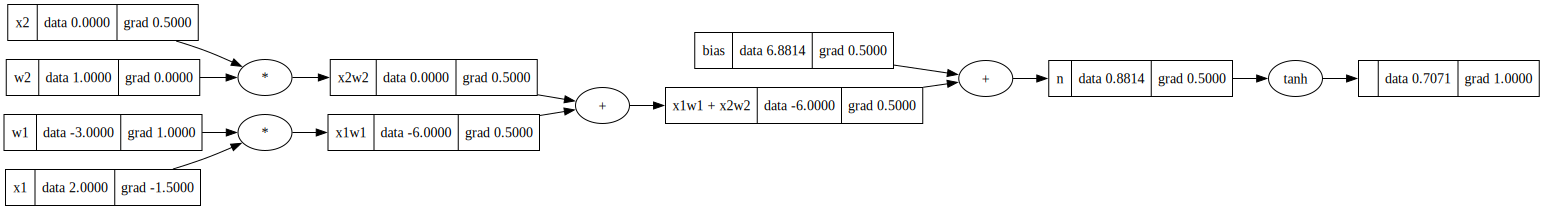

In [48]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

# heading 2
now to help us not calling the "._backward()" function again and again, we define a function named backward in the recent definitions of our functions. {cell 106}

In [73]:
o.backward()

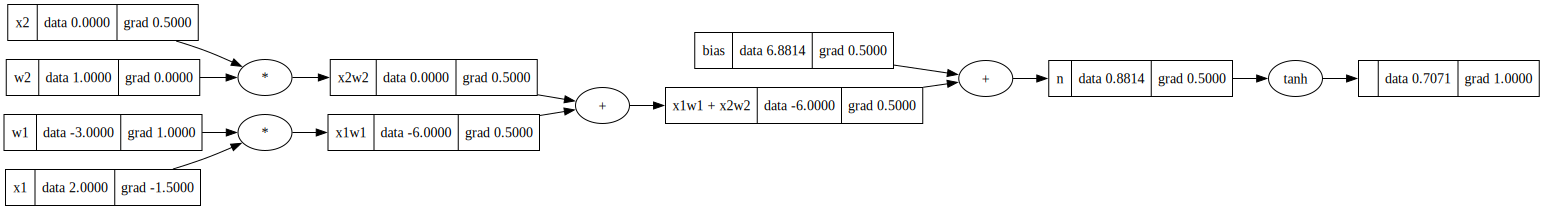

In [74]:
draw_dot(o)

THE BELOW CELL'S EXPLANATION IS DONE ABOVE. 4TH MULTI-LINE COMMENT IN CELL 106

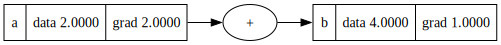

In [82]:
a = Value(2.0); a.label = 'a'
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)